# 猫狗分类任务

In [1]:
# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt

### 数据预处理

In [3]:
# 数据增强
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # 对图像进行随机的crop后再resize成固定的大小
    transforms.RandomRotation(20), # 随机选择角度
    transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
    transforms.ToTensor()
])

In [4]:
# 导入数据
root = './data/dog_vs_cat'
train_dataset = datasets.ImageFolder(root + '/simple_train', transform)
test_dataset = datasets.ImageFolder(root + '/simple_eval', transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [5]:
# 查看训练集
classes = train_dataset.classes
classes_index = train_dataset.class_to_idx

print(classes)
print(classes_index)

['cat', 'dog']
{'cat': 0, 'dog': 1}


### 载入模型

实际上是卷积层与池化层的叠加

- 卷积层 - 特征提取，再把特征传给全连接层
- 全连接层 - 分类

In [6]:
model = models.vgg16(pretrained=True)

# 打印模型结构
print(model)

D:\Download\anaconda3\envs\deep_learn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Download\anaconda3\envs\deep_learn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\明月空悬/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 迁移学习

使用原模型的卷积层，计算完后再使用自己定义的新全连接层完成特定任务

In [7]:
# 原网络的参数不进行训练 -> 只训练自己的新全连接层
##非必须
for parma in model.parameters():
    parma.requires_grad = False
    
# 新的全连接层
model.classifier = nn.Sequential(nn.Linear(25088, 100), 
                                 nn.ReLU(), 
                                 nn.Dropout(p=0.5), 
                                 nn.Linear(100, 2))

In [8]:
LR = 0.0003
# 损失函数
entropy_loss = nn.CrossEntropyLoss()
# 优化器
optimizer = optim.Adam(model.parameters(), LR)

### 定义训练与测试方法

In [9]:
def train():
    model.train()
    for i, data in enumerate(train_loader):
        # 数据与标签
        inputs, labels = data
        # 模型预测结果
        out = model(inputs)
        # 损失函数
        loss = entropy_loss(out, labels)
        # 梯度清零
        optimizer.zero_grad()
        # 梯度计算
        loss.backward()
        # 更新权值
        optimizer.step()

In [10]:
train_acc = []
test_acc = []

def test():
    model.eval()
    correct = 0
    
    for i, data in enumerate(test_loader):
        # 数据与标签
        inputs, labels = data
        # 模型预测结果
        out = model(inputs)
        # 最大值及其所在位置
        _, predicted = torch.max(out, 1)
        # 正确的数量
        correct += (predicted == labels).sum()
        
    acc = correct.item() / len(test_dataset)
    test_acc.append(acc)
    print(f'Test acc: {acc}')
    
    correct = 0
    for i, data in enumerate(train_loader):
        # 数据与标签
        inputs, labels = data
        # 模型预测结果
        out = model(inputs)
        # 最大值及其所在位置
        _, predicted = torch.max(out, 1)
        # 正确的数量
        correct += (predicted == labels).sum()
        
    acc = correct.item() / len(train_dataset)
    train_acc.append(acc)
    print(f'Train acc: {acc}')

### 训练

In [11]:
for epoch in range(10):
    print('epoch: ', epoch)
    train()
    test()

epoch:  0
Test acc: 0.87
Train acc: 0.869
epoch:  1
Test acc: 0.895
Train acc: 0.878
epoch:  2
Test acc: 0.875
Train acc: 0.8865
epoch:  3
Test acc: 0.905
Train acc: 0.893
epoch:  4
Test acc: 0.86
Train acc: 0.896
epoch:  5
Test acc: 0.91
Train acc: 0.9045
epoch:  6
Test acc: 0.905
Train acc: 0.9035
epoch:  7
Test acc: 0.91
Train acc: 0.9045
epoch:  8
Test acc: 0.87
Train acc: 0.908
epoch:  9
Test acc: 0.915
Train acc: 0.904


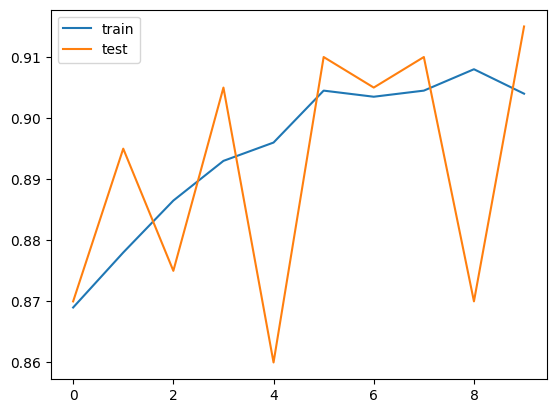

In [12]:
plt.plot(range(10), train_acc, label='train')
plt.plot(range(10), test_acc, label='test')
plt.legend()
plt.show()

In [13]:
torch.save(model.state_dict(), 'model/cat_dog.pth')